# 遗传算法

## 问题1

$$Max(\sqrt{x_1}+\sqrt{x_2}+\sqrt{x_3})\\
x_1^2+2x_2^2+3x_3^2\le1\\
x_1,x_2,x_3\ge 0$$

### 设置函数

定义目标函数，并设计适应度函数。
由于这是一个约束问题，需要满足的约束条件比较复杂，所以需要做特殊的处理。经查阅文献知，在GA中对约束问题的处理方法可以分成以下几种。
1. 拒绝
只要是不再解空间中的染色体，就直接扔掉。但是由于很多约束优化问题初始种群由非可行染色体构成，就需要对他们进行修补，而且在解空间很小的情况下，很容易杀死种群中的全部个体，使算法提前终止。
2. 修复
将不可行的染色体修复成可行的。修复的程序依赖于具体的问题，有些问题修复过程比原问题还要复杂。
修复之后的染色体可以用来做评估，也可以替代原染色体进行遗传。
3. 改进遗传算子
将问题换一种形式，改变遗传算子的操作等，让不行解不出现。
4. 惩罚
过程中可能出现不可行的染色体，但是在适应函数中对这种染色体进行惩罚。这样，就把约束问题转换成了无约束问题。

在本问题中，我采用了拒绝方法对约束进行限制。（其实是在惩罚函数的框架下，但是让不满足条件的个体适应度直接变成0）

In [14]:
import numpy as np
import math
def aim(variables,legV):
    '''其中legV是可行性列向量'''
    x1 = variables[:,[0]]
    x2 = variables[:,[1]]
    x3 = variables[:,[2]]
    sqrt = np.vectorize(math.sqrt)
    f = sqrt(x1) + sqrt(x2) + sqrt(x3)
    idx1 = np.where(x1**2 + 2*x2**2 + 3*x3**2 >1)[0]#采用惩罚方法对于不可行解进行惩罚
    #f[idx1] = 0
    exIdx = np.unique(np.hstack([idx1])) # 得到非可行解个体的下标
    legV[exIdx] = 0 # 标记非可行解在种群可行性列向量中对应的值为0(0表示非可行解，1表示可行解)
    return [f,legV]

def punishing(LegV, FitnV):
    FitnV[np.where(LegV == 0)[0]] = 0 # 惩罚非可行解个体的适应度
    return FitnV

### 编写遗传算法模板

本模板采用的编码方式为实值编码，即染色体中的每个位点对应于实数表达式中的一位。  

AIM :目标函数  

PUN :罚函数

FieldDR : array - 实际值种群区域描述 指定每个变量的上下界[lowerbound, upperbound]

problem : str - 表明是整数问题还是实数问题，'I'表示是整数问题，'R'表示是实数问题   

maxormin int - 最小最大化标记，1表示目标函数最小化；-1表示目标函数最大化

MAXGEN : int - 最大遗传代数

NIND : int - 种群规模，即种群中包含多少个个体

SUBPOP : int - 子种群数量，即对一个种群划分多少个子种群

GGAP ：代沟

selectStyle : str - 指代所采用的低级选择算子的名称，如'rws'(轮盘赌选择算子)

recombinStyle: str - 指代所采用的低级重组算子的名称，如'xovsp'(单点交叉)

recopt : float - 交叉概率

pm : float - 变异概率

drawing : int - (可选参数)，0表示不绘图，1表示绘制最终结果图，2表示绘制动画。默认drawing为1

输出参数：

pop_trace : array - 种群进化记录器(进化追踪器),

第0列记录着各代种群最优个体的目标函数值

第1列记录着各代种群的适应度均值
第2列记录着各代种群最优个体的适应度值
    
 var_trace : array - 变量记录器，记录着各代种群最优个体的变量值，每一列对应一个控制变量
    
 times : float - 进化所用时间


In [15]:
import geatpy as ga
import time

def GAtemplate(AIM, PUN, FieldDR, problem, maxormin, GGAP, MAXGEN, NIND, SUBPOP, selectStyle, recombinStyle, recopt, pm, drawing = 1):
    GGAP = 0.5 # 因为父子合并后选择，因此要将代沟设为0.5以维持种群规模
    aimfuc = AIM
    if PUN is not None:
        punishing = PUN # 获得罚函数
    NVAR = FieldDR.shape[1] # 得到控制变量的个数
    # 定义进化记录器，初始值为nan
    pop_trace = (np.zeros((MAXGEN ,2)) * np.nan)
    # 定义变量记录器，记录控制变量值，初始值为nan
    var_trace = (np.zeros((MAXGEN ,NVAR)) * np.nan) 
    repnum = 0 # 初始化重复个体数为0
    ax = None # 存储上一帧图形

    if problem == 'R':
        Chrom = ga.crtrp(NIND, FieldDR) # 生成初始种群
    elif problem == 'I':
        Chrom = ga.crtip(NIND, FieldDR)
    LegV = np.ones((NIND, 1)) # 生成可行性列向量，元素为1表示对应个体是可行解，0表示非可行解
    [ObjV, LegV] = aimfuc(Chrom, LegV) # 求初代的目标函数值
    gen = 0
    badCounter = 0 # 用于记录在“遗忘策略下”被忽略的代数
    # 开始进化！！
    start_time = time.time() # 开始计时
    while gen < MAXGEN:
        if badCounter >= 10 * MAXGEN: # 若多花了10倍的迭代次数仍没有可行解出现，则跳出
            break
        # 进行遗传算子，生成子代
        SelCh=ga.recombin(recombinStyle, Chrom, recopt, SUBPOP) # 重组
        if problem == 'R':
            SelCh=ga.mutbga(SelCh,FieldDR, pm) # 变异
        elif problem == 'I':
            SelCh=ga.mutint(SelCh, FieldDR, pm) #变异：整数
        LegVSel = np.ones((SelCh.shape[0], 1)) # 初始化育种种群的可行性列向量
        [ObjVSel, LegVSel] = aimfuc(SelCh, LegVSel) # 求育种种群的目标函数值
        # 父子合并
        Chrom = np.vstack([Chrom, SelCh])
        ObjV = np.vstack([ObjV, ObjVSel])
        LegV = np.vstack([LegV, LegVSel])
        # 对合并的种群进行适应度评价
        FitnV = ga.ranking(maxormin * ObjV, LegV, None, SUBPOP)
        if PUN is not None:
            FitnV = punishing(LegV, FitnV) # 调用罚函数
        # 记录进化过程
        bestIdx = np.argmax(FitnV) # 获取最优个体的下标
        if LegV[bestIdx] != 0:
            feasible = np.where(LegV != 0)[0] # 排除非可行解
            pop_trace[gen,0] = np.sum(ObjV[feasible]) / ObjV[feasible].shape[0] # 记录种群个体平均目标函数值
            pop_trace[gen,1] = ObjV[bestIdx] # 记录当代目标函数的最优值
            var_trace[gen,:] = Chrom[bestIdx, :] # 记录当代最优的控制变量值
            repnum = len(np.where(ObjV[bestIdx] == ObjV)[0]) # 计算最优个体重复数
            # 绘制动态图
            if drawing == 2:
                ax = ga.sgaplot(pop_trace[:,[1]],'种群最优个体目标函数值', False, ax, gen)
        else:
            gen -= 1 # 忽略这一代
            badCounter += 1
        [Chrom,ObjV,LegV]=ga.selecting(selectStyle, Chrom, FitnV, GGAP, SUBPOP, ObjV, LegV) # 选择个体生成新一代种群
        gen += 1
    end_time = time.time() # 结束计时
    times = end_time - start_time
    # 绘图
    if drawing != 0:
        ga.trcplot(pop_trace, [['种群个体平均目标函数值', '种群最优个体目标函数值']])
    # 输出结果
    if maxormin == 1:
        best_gen = np.argmin(pop_trace[:, 1]) # 记录最优种群是在哪一代
        best_ObjV = np.min(pop_trace[:, 1])
    elif maxormin == -1:
        best_gen = np.argmax(pop_trace[:, 1]) # 记录最优种群是在哪一代
        best_ObjV = np.max(pop_trace[:, 1])
    if np.isnan(best_ObjV):
        raise RuntimeError('error: no feasible solution. (没找到可行解。)')
    print('最优的目标函数值为：', best_ObjV)
    print('最优的控制变量值为：')
    for i in range(NVAR):
        print(var_trace[best_gen, i])
    print('最优的一代是第', best_gen + 1, '代')
    print('时间已过', times, '秒')
    # 返回进化记录器、变量记录器以及执行时间
    return [pop_trace, var_trace, times]


### 实际问题求解

先找到边界，然后从边界开始搜索。可以直接调用内置模板，但是为了更直观地展现过程，所以使用之前编写过的简化过的模板。

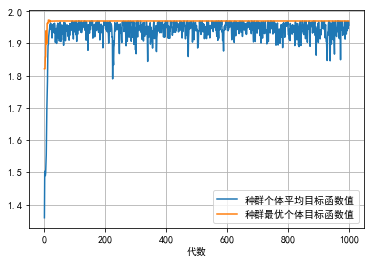

最优的目标函数值为： 1.972194164987945
最优的控制变量值为：
0.5537167397557463
0.4173777423511609
0.3387530116704016
最优的一代是第 14 代
时间已过 1.9777874946594238 秒


In [16]:
import geatpy as ga

# 变量设置
x1 = [0, 2]                        # 自变量1的范围
x2 = [0, 1]                      # 自变量2的范围
x3 = [0, 1]                      # 自变量3的范围
b1 = [1, 1]                          # 自变量1是否包含界
b2 = [1, 1]                          # 自变量2是否包含界
b3 = [1, 1]                          # 自变量3是否包含界
ranges = np.vstack([x1, x2, x3]).T       # 生成自变量的范围矩阵
borders = np.vstack([b1, b2, b3]).T      # 生成自变量的边界矩阵
FieldDR = ga.crtfld(ranges, borders) # 生成区域描述器
# 调用模板
[pop_trace, var_trace, times] = GAtemplate(aim, punishing, FieldDR, problem = 'R', maxormin = -1, MAXGEN = 1000, NIND = 30, SUBPOP = 1, GGAP = 0.9, selectStyle = 'tour', recombinStyle = 'xovdp', recopt = 0.9, pm = 0.3, drawing = 1)

#也可以调greatpy内置的算法模板
#AIM=__import__('aim')
#[pop_trace, var_trace, times] = ga.sga_new_real_templet(AIM,'aim',None,None,FieldDR, problem = 'I', maxormin = -1, MAXGEN = 1000, NIND = 100, SUBPOP = 1, GGAP = 0.9, selectStyle = 'tour', recombinStyle = 'xovdp', recopt = 0.9, pm = 0.3, distribute = True,drawing = 1)

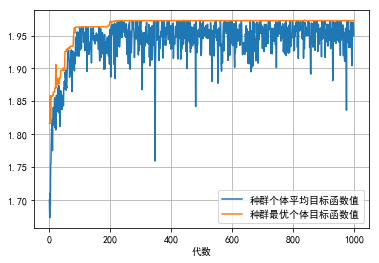

最优的目标函数值为： 1.9734660742992167
最优的控制变量值为：
0.6122357266065648
0.3609160092492558
0.34839303485824613
最优的一代是第 838 代
时间已过 2.162379741668701 秒


In [17]:
[pop_trace, var_trace, times] = GAtemplate(aim, punishing, FieldDR, problem = 'R', maxormin = -1, MAXGEN = 1000, NIND = 30, SUBPOP = 1, GGAP = 0.9, selectStyle = 'rws', recombinStyle = 'xovdp', recopt = 0.9, pm = 0.3, drawing = 1)

## 问题2：用GA解目标规划问题

$$Lex Min(d_1^-,d_2^-,d_3^-)\\
3-\sqrt{x_1}=d_1^-\\
4 -\sqrt{x_1+2x_2}=d_2^-\\
5-\sqrt{x_1+2x_2+3x_3}=d_3^-\\
x_1^2+x_2^2+x_3^2\le 100\\
x_1,x_2,x_3\ge 0$$

### 编写目标函数和惩罚函数

在编写目标规划的目标函数的时候，由于有三个优先级，所以给3个不同的优先级乘上3个不同的权重系数，不妨分别为1000,100和1。

In [18]:
def aim(variables,legV):
    '''其中legV是可行性列向量'''
    x1 = variables[:,[0]]
    x2 = variables[:,[1]]
    x3 = variables[:,[2]]
    sqrt = np.vectorize(math.sqrt)
    Max = np.vectorize(max)
    obj1 = np.abs(3 - sqrt(x1))
    obj2 = np.abs(4-sqrt(x1+2*x2))
    obj3 = np.abs(5-sqrt(x1+2*x2+3*x3))
    f = 1000*obj1 + 100*obj2 +obj3
    idx1 = np.where(x1**2 + x2**2 + x3**2 >100)[0]#采用惩罚方法对于不可行解进行惩罚
    idx2 = np.where(3 - sqrt(x1)<0)[0]
    idx3 = np.where(4 - sqrt(x1+2*x2)<0)[0]
    idx4 = np.where(5 - sqrt(x1+2*x2+3*x3)<0)[0]
    f[idx1] = 0
    f[idx2] = 0
    f[idx3] = 0
    f[idx4] = 0
    exIdx = np.unique(np.hstack([idx1,idx2,idx3,idx4])) # 得到非可行解个体的下标
    legV[exIdx] = 0 # 标记非可行解在种群可行性列向量中对应的值为0(0表示非可行解，1表示可行解)
    return [f,legV]


### 对实际问题进行求解

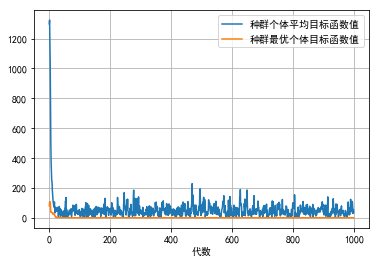

最优的目标函数值为： 0.12365047189440492
最优的控制变量值为：
8.999991517793449
3.4999971323820693
2.598107368571882
最优的一代是第 360 代
时间已过 3.684211015701294 秒


In [19]:
# 变量设置
x1 = [0, 10]                        # 自变量1的范围
x2 = [0, 8]                      # 自变量2的范围
x3 = [0, 9]                      # 自变量3的范围
b1 = [1, 1]                          # 自变量1是否包含界
b2 = [1, 1]                          # 自变量2是否包含界
b3 = [1, 1]                          # 自变量3是否包含界
ranges = np.vstack([x1, x2, x3]).T       # 生成自变量的范围矩阵
borders = np.vstack([b1, b2, b3]).T      # 生成自变量的边界矩阵
FieldDR = ga.crtfld(ranges, borders) # 生成区域描述器
# 调用模板
[pop_trace, var_trace, times] = GAtemplate(aim, punishing, FieldDR, problem = 'R', maxormin = 1, MAXGEN = 1000, NIND = 100, SUBPOP = 1, GGAP = 0.9, selectStyle = 'tour', recombinStyle = 'xovdp', recopt = 0.9, pm = 0.5, drawing = 1)


注：如果直接让优化的目标为$max(3-\sqrt{x_1})$，则函数的最优解始终会记录0，因为可能产生让$3-\sqrt{x_1}$等三个目标式都小于0的染色体，但是这种情况下的$x_1,x_2,x_3$不会被记录下来，从而产生最优控制变量和最优解不对应的情况。要修正这个问题非常简单，只需要将原来的目标函数加上绝对值，并增加目标式必须为正数的约束条件即可。上面是修正之后的结果。

# 神经元网络算法

在神经元网络的部分，我主要用了两种方式来实现：

1. 自定义神经元网络的类，使用梯度下降法实现神经元网络参数的更新，从而减小误差
2. 利用Pytorch深度学习框架，搭建多层神经元网络，使用误差反向传播法训练，选择Adam的参数优化方式，实现神经元网络的快速收敛

## 输出是单个值的例子

$$f(x_1,x_2,x_3,x_4)=\sin{x_1}+\sin{x_2}+\sin{x_3}+\sin{x_4}\\
x_i \in [0,2\pi],i\in\{1,2,3,4\}$$

In [20]:
def sigm(x):
    return 1.0/(1.0+math.exp(-x))

def f(x):# 要逼近的函数，用于生成样本
    return(list(map(lambda x : sum(np.sin(x).tolist()),x)))

def sample(a,b,n):#生成n个样本
    array=np.random.rand(4,n)*(b-a)+a
    y = f(np.transpose(array))
    return ([np.transpose(array),y])

class NN():
    def __init__(self,a,b,n_sam,ni,nh,no):
        self.W1 = np.random.random((nh,ni)) #输入层与隐层之间的权重
        self.B1 = np.random.random((nh,1)) #隐含层神经元的阈值
        self.W2 = np.random.random((no,nh)) #隐含层与输出层之间的权重
        self.B2 = np.random.random((no,1)) #输出层神经元的阈值
        self.threshold = 0.05 #学习速率
        self.max_steps = 1000
        self.ni = ni
        self.nh = nh
        self.no = no
        self.Z1 = None
        self.A1 = None
        self.E = []#平均误差随迭代次数的变化
        self.Z2 = np.zeros((n_sam,no)) # 模型的输出结果
        self.a =a
        self.b=b
        self.n_sam=n_sam
    def predict(self,x):#一遍向前，计算结果
        sigmoid = np.vectorize(sigm)
        self.Z1 = np.dot(self.W1,x.T)+self.B1 # 隐含层输入数据          
        self.A1 = sigmoid(self.Z1) #输出数据
        self.Z2 = np.dot(self.W2,self.A1) + self.B2 #模型输出
        return self.Z2
    def back_propagate(self,x,y):
        sigmoid = np.vectorize(sigm)
        temp = 0
        e = np.add(self.Z2,-y)#误差项
        dZ2 = e  #梯度下降
        dW2 = np.dot(dZ2,self.A1.T)/self.n_sam
        dB2 = np.sum(dZ2,axis=1,keepdims=True)/self.n_sam
        dZ1 = np.dot(self.W2.T,dZ2)*(1-np.power(self.A1,2))
        dW1 = np.dot(dZ1,x)/self.n_sam
        dB1 = np.sum(dZ1,axis=1,keepdims=True)/self.n_sam
        self.W1 = self.W1 - self.threshold*dW1
        self.B1 = self.B1 - self.threshold*dB1
        self.W2 = self.W2 - self.threshold*dW2
        self.B2 = self.B2 - self.threshold*dB2
        temp = np.sum(abs(e))/self.n_sam
        return temp
    def train(self,x,y):
        e = 1
        while e >= 0.01:
            for k in range(self.max_steps):
                self.predict(x)
                e = self.back_propagate(x,y)
                self.E.append(e)
            print(e)
    def test(self):
        samples = sample(self.a,self.b,self.n_sam)
        x = samples[0]
        y = np.array(samples[1])
        self.train(x,y)
        print(self.predict(x),'\n')

#nn= NN(0,2*math.pi,1000,4,10,1)
#nn.test()
#samples = sample(0,2*math.pi,1000)
#x = samples[0]
#y = np.array(samples[1])
#nn.train(x,y)

由于自己写的神经网络实在是太慢了，效果也不是很好，所以我使用pytorch深度学习框架，手动搭建神经元网络，优化参数更新方式，更快地实现函数逼近。
tensor指的就是高维向量，和Numpy数组比较像,速度非常快

In [21]:
import torch 
from torch.autograd import Variable
import torch.nn.functional as F

samples = sample(0,2*math.pi,1000)
x = samples[0]
y = np.array([samples[1]])
x = torch.from_numpy(x)
y = torch.from_numpy(y)
x,y = x.float() , y.float() #如果不用float 精度跟不上

## 搭建神经元网络
class NN(torch.nn.Module):
    def __init__(self,ni,nh,no):
        super(NN,self).__init__() #继承神经元网络的父类
        self.hidden = torch.nn.Linear(ni,nh)#隐藏层
        self.predict = torch.nn.Linear(nh,no) #预测
        
    def forward(self,x): #向前
        x = torch.relu(self.hidden(x)) #参数传递到隐藏层
        x = self.predict(x) #预测
        return x

## 建立神经元网络
net = NN(4,10,1)
##优化神经网络
optimizer = torch.optim.Adam(net.parameters(),lr = 0.05)
loss = torch.nn.MSELoss() 
for t in range(1000):
    prediction = net(x)
    loss_value = loss(prediction,y) #算误差
    optimizer.zero_grad()#先把梯度降成0，免得梯度爆炸
    loss_value.backward() #反向传播
    optimizer.step() #优化梯度
    
net = net.eval() # 转换成测试模式

## 下面试验搭建的神经元网络的预测效果，以[0,0,0,0]为例
data_X = torch.Tensor([0,0,0,0])
var_data = Variable(data_X)
pred_test = net(var_data) # 测试集的预测结果
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()
pred_test


array([0.03416206], dtype=float32)

## 向量的例子

$$ \begin{equation}  f(x_1,x_2,x_3,x_4,x_5,x_6)= \left(
  \begin{array}{c} 
   x_1ln(x_2)& +x_2ln(x_3) \\ 
    x_3ln(x_4)&+x_4ln(x_5) \\  
    x_5ln(x_6)&+x_6ln(x_1)\end{array}\right)               
\end{equation}\\
x_i \in [1,5]$$


In [22]:
def f(x):# 要逼近的函数，用于生成样本  
    y1 = list(map(lambda x:np.log(x[1])*x[0]+np.log(x[2])*x[1],x))
    y2 = list(map(lambda x:np.log(x[3])*x[2]+np.log(x[4])*x[3],x))
    y3 = list(map(lambda x:np.log(x[5])*x[4]+np.log(x[0])*x[5],x))
    y = np.array([y1,y2,y3])
    return(y)

def sample(a,b,n):#生成(a,b)间n组样本
    array=np.random.rand(6,n)*(b-a)+a
    y = f(np.transpose(array))
    return ([np.transpose(array),np.transpose(y)])

## 生成样本
sam = sample(1,5,1000)
x = sam[0]
y = np.array(sam[1])
x = torch.from_numpy(x)
y = torch.from_numpy(y)

x,y = Variable(x), Variable(y)
x,y = x.float() , y.float()

net = NN(6,15,3)

##优化神经网络
optimizer = torch.optim.SGD(net.parameters(),lr = 0.01)
loss = torch.nn.MSELoss() 
for t in range(1000):
    prediction = net(x)
    loss_value = loss(prediction,y) #算误差
    optimizer.zero_grad()#先把梯度降成0，免得梯度爆炸
    loss_value.backward() #反向传播
    optimizer.step() #优化梯度


In [23]:
#进行测试 ，以[e,e,e,e,e,e]为例，返回值应该逼近（2e,2e,2e,2e)
net = net.eval() # 转换成测试模式
data_X = torch.Tensor([math.e,math.e,math.e,math.e,math.e,math.e])
var_data = Variable(data_X)
pred_test = net(var_data) # 测试集的预测结果
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()
pred_test

array([5.1219583, 5.300033 , 5.2273035], dtype=float32)

# 混合遗传算法

1. 通过模拟，生成变量样本x,y
2. 根据1中的样本，标签训练一个NN来逼近这个含随机变量的函数的值
3. 指定种群数量n，产生n个染色体，他们的可行性用2中的NN来衡量
4. 遗传算子
5. 计算每个染色体的纳什均衡，用神经元网络来解目标值
6. 用目标值来衡量每个染色体的可行性
7. 用轮盘赌来选择
8. 重复上述过程
9. 返回斯坦伯格-纳什均衡， 即为最优解

## 随机变量搜索

$$ min E\sqrt{(x_1-\xi_1)^2+(x_2-\xi_2)^2+(x_3-\xi_3)^2}\\
x_1^2+x_2^2+x_3^2\le 10\\
\xi_1 \sim U(1,2),\xi_2 \sim N(3,1),\xi_3 \sim exp(4)$$

In [24]:
## 计算样本目标值的函数
def calculate_y(x):
    aim = []
    for i in range(len(x)):
        v1 = np.random.uniform(1,2,3000)
        v2 = np.random.normal(3,1,3000)
        v3 = np.random.exponential(4,3000)
        fx = np.sqrt((v1-x[i][0])**2+(v2-x[i][1])**2+(v3-x[i][0])**2).mean()
        aim.append(fx) #对每一个随机数，计算均值
    return np.array(aim)

## 抽样函数
def sample(a,b,n):#生成样本x1,x2,x3,他们都在0-4之间而且满足约束
    a = np.array(np.random.rand(3,n)*(b-a)+a)
    condition = np.where(a[0]**2+a[1]**2+a[2]**2<=10)
    b = np.transpose(a)[condition]
    return b

## 生成样本
x= sample(0,4,5000)
y =calculate_y(x)
n_sam = len(x)
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

In [25]:
## 训练神经元网络
net = NN(3,15,1)
optimizer = torch.optim.RMSprop(net.parameters(),lr = 0.01)
loss = torch.nn.MSELoss() 

for t in range(1000):
    prediction = net(x)
    loss_value = loss(prediction,y) #算误差
    optimizer.zero_grad()#先把梯度降成0，免得梯度爆炸
    loss_value.backward() #反向传播
    optimizer.step() #优化梯度

#转化成测试模式
net = net.eval()

In [26]:
#逼近函数,输入为x，是个array,输出也是个array，即输出目标函数
def appro_func(x):
    data_X = torch.from_numpy(x)
    data_X = data_X.float()
    var_data = Variable(data_X)
    pred_test = net(var_data) # 测试集的预测结果
    # 改变输出的格式
    pred_test = pred_test.view(-1).data.numpy()
    return np.array([pred_test])

# 修改适应性函数
def aim(variables,legV):
    '''其中legV是可行性列向量'''
    x1 = variables[:,[0]]
    x2 = variables[:,[1]]
    x3 = variables[:,[2]]
    f = appro_func(np.concatenate((x1,x2,x3),axis=1))
    idx1 = np.where(x1**2 + x2**2 + x3**2 >10)[0]#采用惩罚方法对于不可行解进行惩罚
    f[0][idx1] = 0
    exIdx = np.unique(np.hstack([idx1])) # 得到非可行解个体的下标
    legV[exIdx] = 0 # 标记非可行解在种群可行性列向量中对应的值为0(0表示非可行解，1表示可行解)
    return [np.transpose(f),legV]


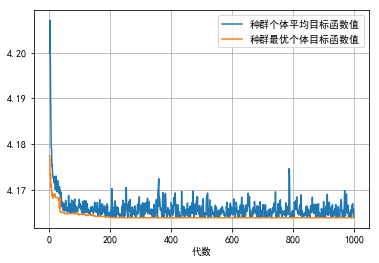

最优的目标函数值为： 4.163848876953125
最优的控制变量值为：
1.760707387541395
2.1664882213763836
1.4853383196952095
最优的一代是第 829 代
时间已过 0.9039349555969238 秒


In [60]:
##开始遗传算法##
# 变量设置
x1 = [0, 4]                        # 自变量1的范围
x2 = [0, 4]                      # 自变量2的范围
x3 = [0, 4]                      # 自变量3的范围
b1 = [1, 1]                          # 自变量1是否包含界
b2 = [1, 1]                          # 自变量2是否包含界
b3 = [1, 1]                          # 自变量3是否包含界
ranges = np.vstack([x1, x2, x3]).T       # 生成自变量的范围矩阵
borders = np.vstack([b1, b2, b3]).T      # 生成自变量的边界矩阵
FieldDR = ga.crtfld(ranges, borders) # 生成区域描述器
# 调用模板,最小化目标函数
[pop_trace, var_trace, times] = GAtemplate(aim, punishing, FieldDR, problem = 'R', maxormin = 1, MAXGEN = 1000, NIND = 30, SUBPOP = 1, GGAP = 0.9, selectStyle = 'tour', recombinStyle = 'xovdp', recopt = 0.9, pm = 0.3, drawing = 1)


## 2 概率函数的例子

$$max \bar{f}\\
Pr(\xi_1 x_1+\xi_2 x_2 +\xi_3 x_3 \ge\bar{f})\ge 0.9\\
Pr(\eta_1 x_1^2+\eta_2 x_2^2 +\eta_3 x_3^2 \le 8)\ge 0.8\\
Pr(\zeta_1 x_1^3 +\zeta_2 x_2^3 +\zeta_3 x_3^3 \le15)\ge0.85\\
x_1,x_2,x_3\ge0\\
\xi_1,\eta_1,\zeta_1 \sim U(1,2);U(2,3);U(3,4)\\
\xi_2,\eta_2,\zeta_2 \sim N(1,1);N(2,1);N(3,1)\\
\xi_3,\eta_3,\zeta_3 \sim exp(1);exp(2);exp(3)
$$

首先，生成计算概率的函数和计算百分数位点的函数。

In [31]:
## 计算概率的函数
def frequency(array,c,direction='s'):
    '''
    input param array：随机数序列
    input param c： 临界值
    input param direction: 's'小于临界值;'b'大于临界值
    return: 满足条件的频率
    '''
    n=len(array)
    if n==0:
        return
    freq=0
    if direction=='s':
        for i in array:
            if i <=c:
                freq+=1
    else:
        for i in array:
            if i>=c:
                freq+=1
    p=freq/n
    return p
## 计算百分位点的函数   
def percentile(array,alpha,lower=False):
    '''
    input param array: 随机数序列
    input param alpha: 百分位点
    input param lower: 下百分位点,默认True
    return percentile：返回百分位点
    '''
    if alpha>1:
        return
    array=np.sort(array)
    n=len(array)
    if lower==False:
        ind=int(round(n*alpha))
    else:
        ind=int(round(n*(1-alpha)))
    return array[ind]


定义生成样本的函数和计算下面几个函数的值
$$u_1 =\{max \bar{f}|Pr(\xi_1 x_1+\xi_2 x_2 +\xi_3 x_3 \ge\bar{f})\ge 0.9\}\\
u_2 = Pr(\eta_1 x_1^2+\eta_2 x_2^2 +\eta_3 x_3^2 \le 8)\\
u_3 = Pr(\zeta_1 x_1^3 +\zeta_2 x_2^3 +\zeta_3 x_3^3 )
$$

In [32]:
def sample(a,b,n):#生成样本x1,x2,x3,为了保证效率，尽量缩小值域
    a = np.array(np.random.rand(3,n)*(b-a)+a)
    return np.transpose(a)

## 计算f的值
def calculate_y(x):
    aim = []
    for i in range(len(x)):
        v1 = np.random.uniform(1,2,3000)
        v2 = np.random.normal(1,1,3000)
        v3 = np.random.exponential(1,3000)
        aim_f = v1*x[i][0]+v2*x[i][1]+v3*x[i][2]
        perc = percentile(aim_f,0.9,lower = True) #下百分位点
        aim.append(perc)
    return np.array(aim)

## 计算第二个约束的概率-u2
def cal_u2(x):
    aim = []
    for i in range(len(x)):
        v1 = np.random.uniform(2,3,3000)
        v2 = np.random.normal(2,1,3000)
        v3 = np.random.exponential(2,3000)
        aim_f = v1*x[i][0]**2+v2*x[i][1]**2+v3*x[i][2]**2
        perc = frequency(aim_f,8)
        aim.append(perc)
    return np.array(aim)

## 计算第三个约束的概率-u3
def cal_u3(x):
    aim = []
    for i in range(len(x)):
        v1 = np.random.uniform(3,4,3000)
        v2 = np.random.normal(3,1,3000)
        v3 = np.random.exponential(3,3000)
        aim_f = v1*x[i][0]**3+v2*x[i][1]**3+v3*x[i][2]**3
        perc = frequency(aim_f,15)
        aim.append(perc)
    return np.array(aim)

## 生成样本
x = sample(0,3,5000) #生成样本,维数 3*n
y = calculate_y(x) #计算对应的函数值
u2 = cal_u2(x) #约束函数
u3 = cal_u3(x) 
x = torch.from_numpy(x)
y = torch.from_numpy(y)
u2 = torch.from_numpy(u2)
u3 = torch.from_numpy(u3)
x,y,u2,u3 = Variable(x), Variable(y),Variable(u2),Variable(u3)
x,y,u2,u3 = x.float() , y.float(),u2.float(),u3.float()
n_sam = len(x) #满足条件的样本个数


分别训练3个神经元网络来逼近上述的3个函数。这里没有选择一层隐藏层的神经元网络，而是选择了多层的。

In [33]:
from sklearn.neural_network import MLPRegressor as MLP 

u1net = MLP(activation='relu', learning_rate='adaptive')
u1net.fit(x,y)
u2net = MLP(activation='relu', learning_rate='adaptive')
u2net.fit(x,u2)
u3net =MLP(activation='relu', learning_rate='adaptive')
u3net.fit(x,u3)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [34]:
# 修改适应性函数
def punishing(LegV, FitnV):
    FitnV[np.where(LegV == 0)[0]] = 0.3 # 惩罚非可行解个体的适应度
    return FitnV
#定义目标函数
def aim(variables,legV):
    '''其中legV是可行性列向量'''
    x1 = variables[:,[0]]
    x2 = variables[:,[1]]
    x3 = variables[:,[2]]
    f = np.array([u1net.predict(np.concatenate((x1,x2,x3),axis=1))])
    f2 = u2net.predict(np.concatenate((x1,x2,x3),axis=1))
    f3 = u3net.predict(np.concatenate((x1,x2,x3),axis=1))
    idx1 = np.where(f2 <0.8)#采用惩罚方法对于不可行解进行惩罚
    idx2 = np.where(f3<0.85) 
    f[0][idx1] = 0
    f[0][idx2] = 0
    exIdx = np.unique(np.hstack([idx1,idx2])) # 得到非可行解个体的下标
    legV[exIdx] = 0 # 标记非可行解在种群可行性列向量中对应的值为0(0表示非可行解，1表示可行解)
    return [np.transpose(f),legV]

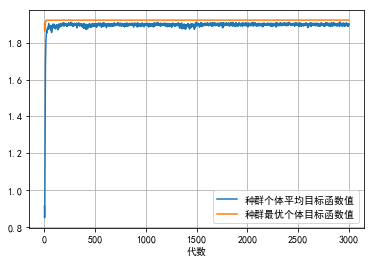

最优的目标函数值为： 1.9218517744236876
最优的控制变量值为：
1.1745911841781895
0.4899471949046874
0.7955282317824379
最优的一代是第 2268 代
时间已过 68.59720659255981 秒


In [35]:
##开始遗传算法##
# 变量设置
x1 = [0, 3]                        # 自变量1的范围
x2 = [0, 2]                      # 自变量2的范围
x3 = [0, 2]                      # 自变量3的范围
b1 = [1, 1]                          # 自变量1是否包含界
b2 = [1, 1]                          # 自变量2是否包含界
b3 = [1, 1]                          # 自变量3是否包含界
ranges = np.vstack([x1, x2, x3]).T       # 生成自变量的范围矩阵
borders = np.vstack([b1, b2, b3]).T      # 生成自变量的边界矩阵
FieldDR = ga.crtfld(ranges, borders) # 生成区域描述器
# 调用模板,最小化目标函数
[pop_trace, var_trace, times] = GAtemplate(aim, punishing, FieldDR, problem = 'R', maxormin = -1, MAXGEN = 3000, NIND = 1000, SUBPOP = 1, GGAP = 0.9, selectStyle = 'tour', recombinStyle = 'xovdp', recopt = 0.9, pm = 0.3, drawing = 1)
